In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [1]:
from birdclef.utils import get_spark
from pyspark.sql import Window, functions as F
import os

spark = get_spark(cores=24, memory="20g")

df = spark.read.parquet("../data/processed/birdclef-2023/train_postprocessed/v7")

In [2]:
df.count()

255372

In [5]:
df.show()

+----------------+----------+----------+-------+--------------------+--------------------+
|      track_stem|track_type|start_time|species|           embedding|      prediction_vec|
+----------------+----------+----------+-------+--------------------+--------------------+
|        XC213642|  original|        55|afmdov1|[1.76885128021240...|[-14.449501, -12....|
|        XC347514|  original|         0|afecuc1|[1.10089623928070...|[-11.292007, -7.0...|
|        XC520009|  original|        10| hoopoe|[1.38337278366088...|[-13.212698, -10....|
|        XC552598|   source2|         0|no_call|[1.02644920349121...|[-12.035065, -11....|
|        XC633814|   source3|         5|yertin1|[0.25436714291572...|[-11.899866, -10....|
|        XC719995|  original|        35| woosan|[1.46683025360107...|[-14.307195, -12....|
|XC214914_part000|   source3|        45|combuz1|[0.83450275659561...|[-15.077307, -12....|
|        XC467122|   source3|        10|no_call|[1.28425991535186...|[-14.257126, -13....|

In [9]:
# track with the highest prediction vec
call_df = (
    df.where("track_type = 'original' and species <> 'no_call'")
    .withColumn("max_pred", F.array_max("prediction_vec"))
    .withColumn(
        "rank",
        F.rank().over(Window.partitionBy("track_stem").orderBy(F.desc("max_pred"))),
    )
    .where("rank = 1")
    .select("species", "embedding")
).toPandas()
call_df

,species,embedding
0,categr,"[1.5999469757080078, 0.9385099411010742, 0.290..."
1,somgre1,"[1.039785623550415, 0.9882990717887878, 0.6820..."
2,greegr,"[1.7132819890975952, 0.9943661093711853, 0.779..."
3,blacuc1,"[0.585594117641449, 1.2963026762008667, 1.3348..."
4,sincis1,"[1.1253572702407837, 1.874013900756836, 0.7012..."
...,...,...
12646,tamdov1,"[1.0972468852996826, 1.3538970947265625, 0.842..."
12647,comsan,"[0.9779160618782043, 1.1506590843200684, 0.702..."
12648,afrgos1,"[1.1771286725997925, 1.3263686895370483, 1.092..."
12649,yebapa1,"[1.4073834419250488, 1.0522592067718506, 1.022..."


In [12]:
call_df.embedding.values[0].shape

(640,)

C:\Users\acmiy\AppData\Local\Temp\ipykernel_6096\2394157022.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(emb[:, 0], emb[:, 1], s=3, alpha=0.5, c=colors, cmap=cmap)


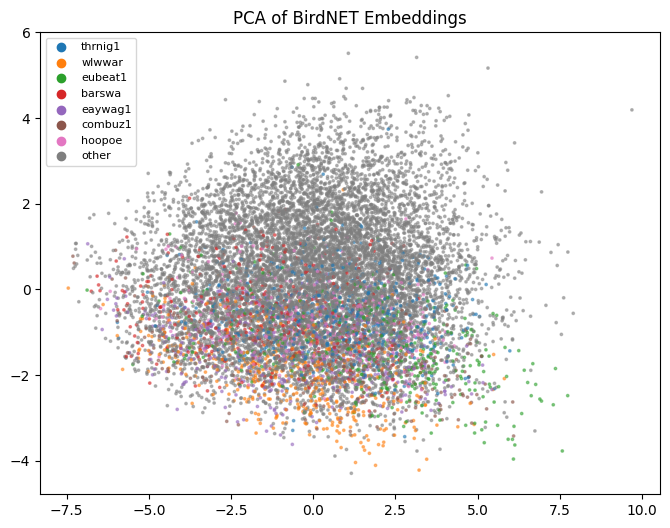

In [73]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


def plot(X, reducer, title=None, colors=None, color_map=None, cmap="tab10", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = plt.gca()
    emb = reducer.fit_transform(X)
    ax.scatter(emb[:, 0], emb[:, 1], s=3, alpha=0.5, c=colors, cmap=cmap)
    if title is not None:
        ax.set_title(title)
    # legend
    for species, color in color_map.items():
        ax.scatter([], [], c=color, label=species)
    ax.legend(fontsize=8)


k = 7
top_species = call_df["species"].value_counts().index[:k].tolist()
color_map = {species: f"C{i}" for i, species in enumerate(top_species)}
color_map["other"] = f"C{k}"
colors = call_df["species"].apply(lambda x: color_map.get(x, f"C{k}"))

X = np.stack(call_df["embedding"].values)[:, :320]
plot(
    X,
    PCA(n_components=2),
    title="PCA of BirdNET Embeddings",
    colors=colors,
    color_map=color_map,
)
plt.show()

C:\Users\acmiy\AppData\Local\Temp\ipykernel_6096\2394157022.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(emb[:, 0], emb[:, 1], s=3, alpha=0.5, c=colors, cmap=cmap)
C:\Users\acmiy\AppData\Local\Temp\ipykernel_6096\2394157022.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(emb[:, 0], emb[:, 1], s=3, alpha=0.5, c=colors, cmap=cmap)


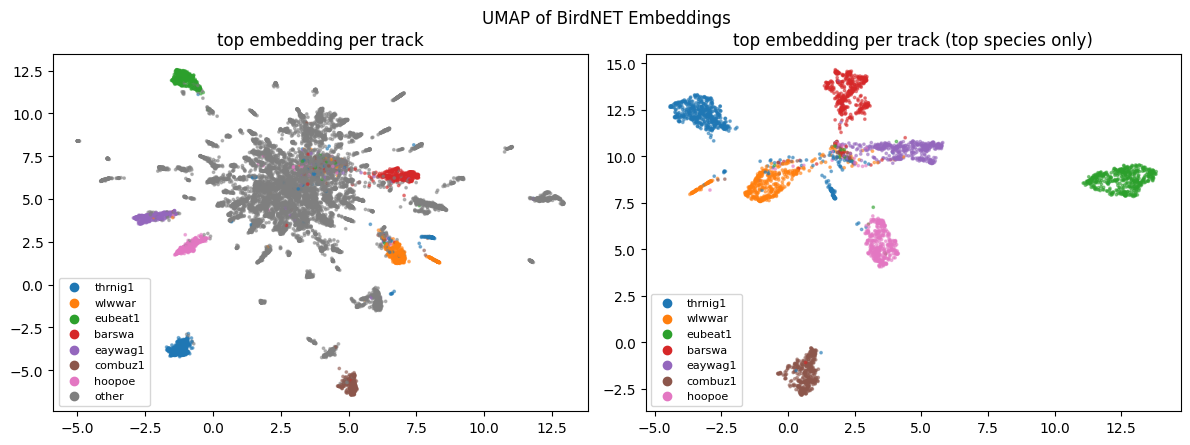

In [76]:
# lets do this for the final plot that we want

# 2x1 plot of umap
scale = 1.5
fig = plt.figure(figsize=(8 * scale, 3 * scale))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fig.suptitle("UMAP of BirdNET Embeddings")
fig.tight_layout()

k = 7
top_species = call_df["species"].value_counts().index[:k].tolist()
color_map = {species: f"C{i}" for i, species in enumerate(top_species)}
color_map["other"] = f"C{k}"
colors = call_df["species"].apply(lambda x: color_map.get(x, f"C{k}"))

X = np.stack(call_df["embedding"].values)[:, :320]
plot(
    X,
    umap.UMAP(n_components=2),
    title="top embedding per track",
    colors=colors,
    color_map=color_map,
    ax=ax1,
)

top_df = call_df[call_df["species"].isin(top_species)]
X = np.stack(top_df["embedding"].values)[:, :320]
del color_map["other"]
colors = top_df["species"].apply(lambda x: color_map.get(x))
plot(
    X,
    umap.UMAP(n_components=2),
    title="top embedding per track (top species only)",
    colors=colors,
    color_map=color_map,
    ax=ax2,
)
plt.show()

In [28]:
# track with the highest prediction vec
call_nocall_df = (
    df.where("track_type = 'original'")
    .withColumn("is_call", F.when(F.col("species") == "no_call", 0).otherwise(1))
    .withColumn("max_pred", F.array_max("prediction_vec"))
    .withColumn(
        "rank",
        F.rank().over(
            Window.partitionBy("track_stem", "is_call").orderBy(F.desc("max_pred"))
        ),
    )
    .where("rank = 1")
    .select("is_call", "embedding")
).toPandas()
call_nocall_df

,is_call,embedding
0,1,"[1.669900894165039, 1.9233328104019165, 0.3780..."
1,1,"[1.0696653127670288, 0.3457373082637787, 0.930..."
2,0,"[1.535396695137024, 1.3291808366775513, 0.8616..."
3,0,"[0.9475569725036621, 1.0884013175964355, 0.414..."
4,0,"[1.427390456199646, 1.0929474830627441, 0.8585..."
...,...,...
23741,1,"[1.3480526208877563, 2.0576250553131104, 0.875..."
23742,0,"[1.2602356672286987, 1.8984524011611938, 0.837..."
23743,1,"[1.5687237977981567, 1.1151937246322632, 0.555..."
23744,0,"[1.616206169128418, 1.6448103189468384, 0.6297..."


{'no call': 'C0', 'call': 'C1'}


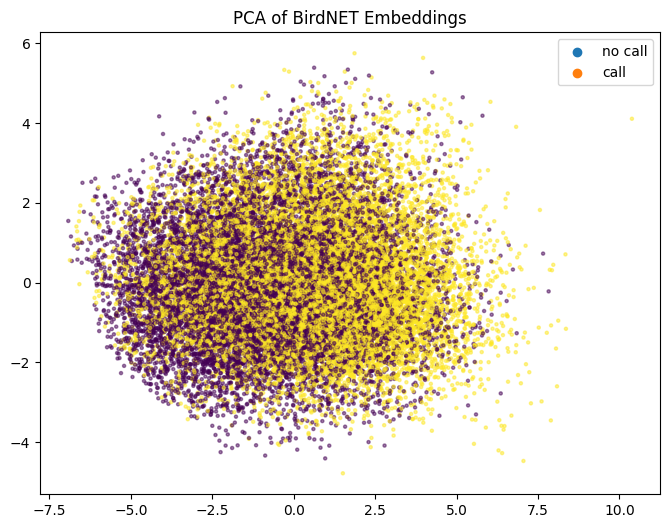

In [39]:
X = np.stack(call_nocall_df["embedding"].values)[:, :320]

plot(
    X,
    PCA(n_components=2),
    title="PCA of BirdNET Embeddings",
    colors=call_nocall_df["is_call"],
    color_map={"no call": "C0", "call": "C1"},
    cmap=None,
)

UMAP( verbose=True)
Sat Jun  3 13:39:31 2023 Construct fuzzy simplicial set
Sat Jun  3 13:39:31 2023 Finding Nearest Neighbors
Sat Jun  3 13:39:31 2023 Building RP forest with 13 trees
Sat Jun  3 13:39:31 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	Stopping threshold met -- exiting after 6 iterations
Sat Jun  3 13:39:31 2023 Finished Nearest Neighbor Search
Sat Jun  3 13:39:31 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:04]


Sat Jun  3 13:39:37 2023 Finished embedding
{'no call': 'C0', 'call': 'C1'}


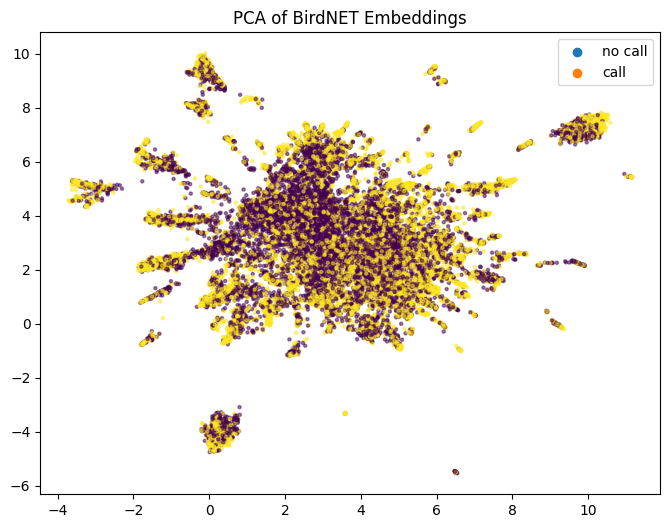

In [40]:
plot(
    X,
    umap.UMAP(n_components=2, verbose=True),
    title="PCA of BirdNET Embeddings",
    colors=call_nocall_df["is_call"],
    color_map={"no call": "C0", "call": "C1"},
    cmap=None,
)